# MINI PROJECT - PDL

In [1]:
import zipfile
import os

# Extracting the samples.zip file
with zipfile.ZipFile('samples.zip', 'r') as zip_ref:
    zip_ref.extractall('samples_data')

# Listing the extracted files
path = 'samples_data/samples/'
print(os.listdir(path))

['nnf8b.png', '6mygb.png', 'cgcgb.png', 'mbf58.png', '6n5fd.png', 'w8bnx.png', 'gegw4.png', 'by5y3.png', '5x7x5.png', 'w6ny4.jpg', 'fp3wy.png', '77wp4.png', 'g6n7x.png', '7nnnx.png', '64b3p.png', 'mcg43.png', 'ng756.png', '5ep3n.png', '7gce6.png', 'b55d6.png', 'm3wfw.png', '5325m.png', 'nmw46.png', 'bny4w.png', '658xe.png', 'nb267.png', '4c8n8.png', 'p6mn8.png', 'mxnw4.png', 'c2g4d.png', 'emwpn.png', 'cfc56.png', '3g2w6.png', 'xcf88.png', '6bnnm.png', 'mbp2y.png', '832f3.png', 'ypw3d.png', '2cg58.png', 'xmcym.png', 'e72cd.png', '6cm6m.png', 'geyn5.jpg', 'c4bny.png', 'f6ww8.png', 'xcmbp.png', '58b5m.png', 'e667x.png', '3c7de.jpg', 'gxx2p.png', 'n7ebx.png', 'n4wwn.png', '8n5pn.png', '8ne4g.png', 'xnn4d.png', '5pm6b.png', 'g7fmc.png', '537nf.png', 'f4wfn.png', 'mc35n.png', 'gdng3.png', 'e76n4.png', '6ge3p.png', 'mfc35.png', '7cgym.png', 'gf2g4.png', 'ppwyd.png', 'ewcf5.png', 'd75b5.png', 'w7e6m.png', '33n73.png', 'bp2d4.png', '3ebnn.png', 'dn5df.png', '38n57.png', '7dgc2.png', '44fyb.png'

In [2]:
#importing libraries
import numpy as np

%matplotlib inline
#to use as command line calls #using inline graphs will come next to code

import matplotlib.pyplot as plt #for graphs
import os #for operating system dependent fucntionality
from keras import layers #for building layers of neural net
from keras.models import Model
from keras.models import load_model
from keras import callbacks #for training logs, saving to disk periodically
import cv2 #OpenCV(Open Source computer vision lib), containg CV algos
import string
import random

In [3]:
# Total number of images in the dataset
n = len(os.listdir(path))
print(f'Total number of images: {n}')

Total number of images: 1071


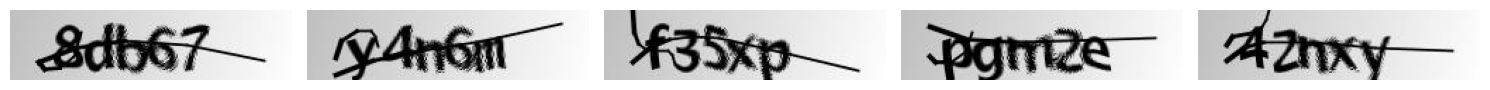

In [4]:
# Display a few sample images
def show_sample_images(path, num_samples=5):
    image_files = os.listdir(path)
    sample_images = random.sample(image_files, num_samples)

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show sample images
show_sample_images(path)

In [5]:
import numpy as np
import string

# Define characters and their count
character = string.ascii_lowercase + "0123456789"
nchar = len(character)
print(f"Characters used: {character}")
print(f"Total number of characters: {nchar}")

# Define image shape
imgshape = (50, 200, 1)

Characters used: abcdefghijklmnopqrstuvwxyz0123456789
Total number of characters: 36


In [6]:
# Preprocess images
def preprocess():
    X = np.zeros((n, 50, 200, 1))  # 1070*50*200 array with all entries 0
    y = np.zeros((5, n, nchar))  # 5*1070*36(5 letters in captcha) with all entries 0

    for i, pic in enumerate(os.listdir(path)):
        # Load image
        img_path = os.path.join(path, pic)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Check if image was loaded correctly
        if img is None:
            print(f"Warning: Unable to read image '{img_path}'. Skipping...")
            continue

        pic_target = pic[:-4]  # drops the .png extension from file name

        if len(pic_target) < 6:  # captcha is not more than 5 letters
            img = img / 255.0  # scale the image between 0 and 1
            img = np.reshape(img, (50, 200, 1))  # reshape to width 200, height 50, channel 1

            target = np.zeros((5, nchar))  # creates an array of size 5*36 with all entries 0

            for j, k in enumerate(pic_target):
                index = character.find(k)  # find position of letter in character string
                if index != -1:
                    target[j, index] = 1  # set 1 for that letter

            X[i] = img  # store image
            y[:, i] = target  # store letter info

    return X, y

In [7]:
# Preprocess the images and get X and y
X, y = preprocess()

# Debug: Check the shape of X and y
print(f"Shape of X: {X.shape}")  # Expected: (number_of_images, 50, 200, 1)
print(f"Shape of y: {y.shape}")  # Expected: (5, number_of_images, 36)

# Split dataset
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Shape of X: (1071, 50, 200, 1)
Shape of y: (5, 1071, 36)
X_train shape: (970, 50, 200, 1), y_train shape: (5, 970, 36)
X_test shape: (101, 50, 200, 1), y_test shape: (5, 101, 36)


In [8]:
from tensorflow.keras import layers, Model

# Create CNN model
def createmodel(imgshape=(50, 200, 1), nchar=36):
    img = layers.Input(shape=imgshape)

    # Conv1 Layer
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)

    # Conv2 Layer
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)

    # Conv3 Layer + Batch Normalization
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)

    # Flatten the feature map
    flat = layers.Flatten()(mp3)

    # Create 5 dense layers for 5 characters
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(nchar, activation='softmax')(drop)
        outs.append(res)

    model = Model(inputs=img, outputs=outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create model and print summary
model = createmodel()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50, 200, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 50, 200, 16)    │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 25, 100, 16)    │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 25, 100, 32)    │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 13, 50, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 13, 50, 32)     │          9,248 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 13, 50, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 7, 25, 32)      │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 5600)           │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │        358,464 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │        358,464 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │        358,464 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │        358,464 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │        358,464 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)  

 Total params: 1,818,196 (6.94 MB)

 Trainable params: 1,818,132 (6.94 MB)

 Non-trainable params: 64 (256.00 B)

In [9]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'] * 5)

# Train model
hist = model.fit(X_train,
                 [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]],
                 batch_size=32,
                 epochs=60,
                 validation_split=0.2)

Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 309ms/step - dense_1_accuracy: 0.0473 - dense_1_loss: 3.7122 - dense_3_accuracy: 0.0367 - dense_3_loss: 3.8773 - dense_5_accuracy: 0.0361 - dense_5_loss: 3.7204 - dense_7_accuracy: 0.0242 - dense_7_loss: 3.7497 - dense_9_accuracy: 0.0618 - dense_9_loss: 3.7734 - loss: 18.8352 - val_dense_1_accuracy: 0.0412 - val_dense_1_loss: 3.5170 - val_dense_3_accuracy: 0.1031 - val_dense_3_loss: 3.4907 - val_dense_5_accuracy: 0.0309 - val_dense_5_loss: 3.5777 - val_dense_7_accuracy: 0.0722 - val_dense_7_loss: 3.4574 - val_dense_9_accuracy: 0.0876 - val_dense_9_loss: 3.5009 - val_loss: 17.5638
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - dense_1_accuracy: 0.0615 - dense_1_loss: 3.4102 - dense_3_accuracy: 0.0748 - dense_3_loss: 3.4609 - dense_5_accuracy: 0.0711 - dense_5_loss: 3.4397 - dense_7_accuracy: 0.0696 - dense_7_loss: 3.4202 - dense_9_accuracy: 0.0744 - dense_9_loss: 3.4364 - loss: 17.1682 - val_dense_1_accuracy: 0.0722 - val_dense_1_loss: 3.

In [10]:
import numpy as np

# Extract the final accuracy for each output from training history
train_accuracies = [
    hist.history['dense_1_accuracy'][-1],
    hist.history['dense_3_accuracy'][-1],
    hist.history['dense_5_accuracy'][-1],
    hist.history['dense_7_accuracy'][-1],
    hist.history['dense_9_accuracy'][-1]
]

val_accuracies = [
    hist.history['val_dense_1_accuracy'][-1],
    hist.history['val_dense_3_accuracy'][-1],
    hist.history['val_dense_5_accuracy'][-1],
    hist.history['val_dense_7_accuracy'][-1],
    hist.history['val_dense_9_accuracy'][-1]
]

# Compute average accuracy
avg_train_acc = np.mean(train_accuracies)
avg_val_acc = np.mean(val_accuracies)

# Print final results
print(f"Final Training Accuracy: {avg_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {avg_val_acc * 100:.2f}%")

Final Training Accuracy: 96.78%
Final Validation Accuracy: 88.56%


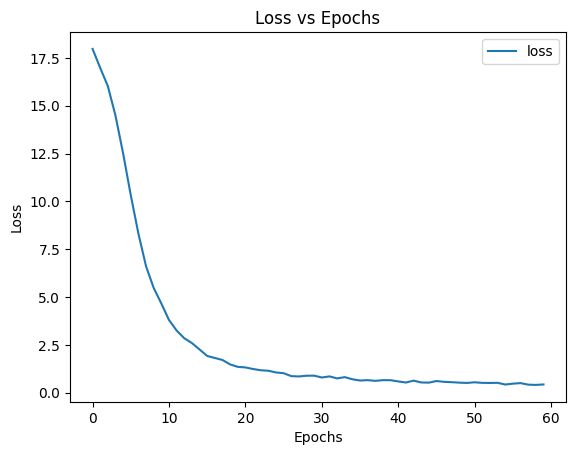

In [11]:
# Graph of Loss vs Epochs
for label in ["loss"]:
    plt.plot(hist.history[label], label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

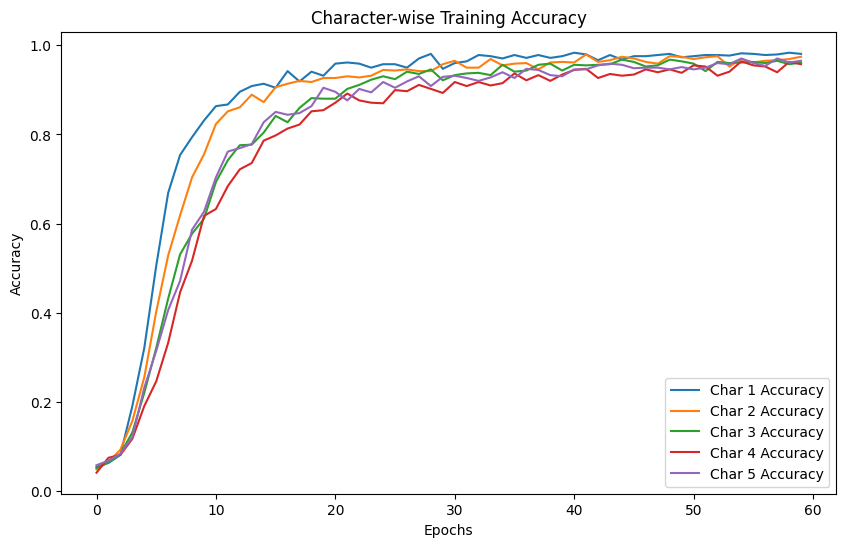

In [12]:
import matplotlib.pyplot as plt

# Correct accuracy keys based on your model's history
accuracy_keys = [
    'dense_1_accuracy',
    'dense_3_accuracy',
    'dense_5_accuracy',
    'dense_7_accuracy',
    'dense_9_accuracy'
]

# Plot training accuracy for each character
plt.figure(figsize=(10, 6))
for i, key in enumerate(accuracy_keys):
    plt.plot(hist.history[key], label=f'Char {i+1} Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Character-wise Training Accuracy")
plt.legend()
plt.show()

In [13]:
# Evaluate model
preds_train = model.evaluate(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]])
print(f"Training Loss: {preds_train[0]}")

preds_test = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print(f"Testing Loss: {preds_test[0]}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - dense_1_accuracy: 0.9980 - dense_1_loss: 0.0023 - dense_3_accuracy: 0.9968 - dense_3_loss: 0.0109 - dense_5_accuracy: 0.9942 - dense_5_loss: 0.0252 - dense_7_accuracy: 0.9924 - dense_7_loss: 0.0390 - dense_9_accuracy: 0.9953 - dense_9_loss: 0.0165 - loss: 0.0924
Training Loss: 0.5534427165985107
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - dense_1_accuracy: 0.9960 - dense_1_loss: 0.0765 - dense_3_accuracy: 0.9623 - dense_3_loss: 0.3022 - dense_5_accuracy: 0.8889 - dense_5_loss: 0.4238 - dense_7_accuracy: 0.8675 - dense_7_loss: 0.4999 - dense_9_accuracy: 0.8758 - dense_9_loss: 0.7361 - loss: 1.8858
Testing Loss: 2.1981797218322754


In [14]:
# Function to predict CAPTCHA
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    if img is not None:
        img = img / 255.0
        img = np.reshape(img, (50, 200, 1))
    else:
        print("Error loading image.")
        return ""

    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    result = np.reshape(res, (5, 36))

    # Get predicted characters
    k_ind = [np.argmax(i) for i in result]
    captcha = ''.join([character[k] for k in k_ind])
    return captcha

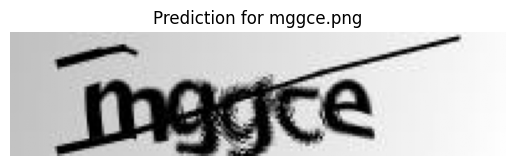

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Predicted CAPTCHA for mggce.png = mggce


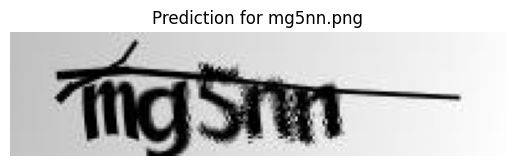

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted CAPTCHA for mg5nn.png = mg5nn


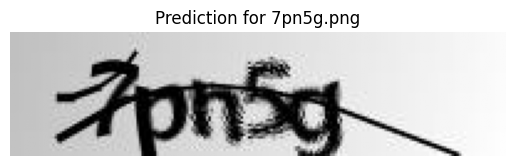

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted CAPTCHA for 7pn5g.png = 7pn5g


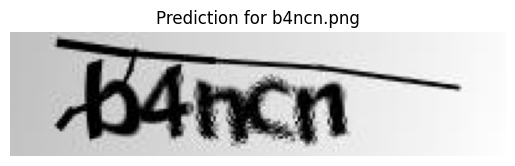

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted CAPTCHA for b4ncn.png = b4ncn


In [15]:
# Predict random samples
random_images = random.sample(os.listdir(path), 4)

for img_name in random_images:
    img_path = os.path.join(path, img_name)

    # Load and display the image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction for {img_name}")
    plt.axis("off")
    plt.show()

    # Predict the CAPTCHA
    print(f"Predicted CAPTCHA for {img_name} = {predict(img_path)}")

In [16]:
# Save the trained model
model.save('captcha_solver_model.h5')
print("Model saved successfully!")

Model saved successfully!


In [17]:
from google.colab import files
import shutil

# Compress samples_data folder before downloading
shutil.make_archive('samples_data', 'zip', 'samples_data')

# Download the trained model
files.download('/content/captcha_solver_model.h5')

# Download the dataset folder (samples_data.zip)
files.download('/content/samples_data')

# Download the original uploaded zip (samples.zip)
files.download('/content/samples.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>